### Below used for debugging individual circuit runs


In [1]:
from qiskit.circuit.library import QuantumVolume, EfficientSU2, TwoLocal, QFT
from qiskit import QuantumCircuit
from qiskit.circuit.library.standard_gates import iSwapGate, CXGate
from qiskit import QuantumCircuit
from qiskit.providers.fake_provider import FakeQuitoV2
from qiskit.transpiler.coupling import CouplingMap
from qiskit.extensions import UnitaryGate
from weylchamber import canonical_gate
from mirror_gates.pass_managers import Mirage, QiskitLevel3
from transpile_benchy.metrics.gate_counts import (
    DepthMetric,
    TotalMetric,
    TotalSwaps,
)
from transpile_benchy.metrics.timer import TimeMetric
from mirror_gates.fast_unitary import FastConsolidateBlocks
from qiskit.transpiler.passes import (
    Collect2qBlocks,
    Unroll3qOrMore,
    ConsolidateBlocks,
)
from qiskit.transpiler import PassManager
import numpy as np
from mirror_gates.logging import transpile_benchy_logger

In [2]:
N = 8
# coupling_map = FakeQuitoV2().target.build_coupling_map()
# coupling_map = CouplingMap.from_grid(4,4)
coupling_map = CouplingMap.from_line(N)
# coupling_map = CouplingMap.from_heavy_hex(5)
# coupling_map.draw()

Loading qft_n4 from QASMBench


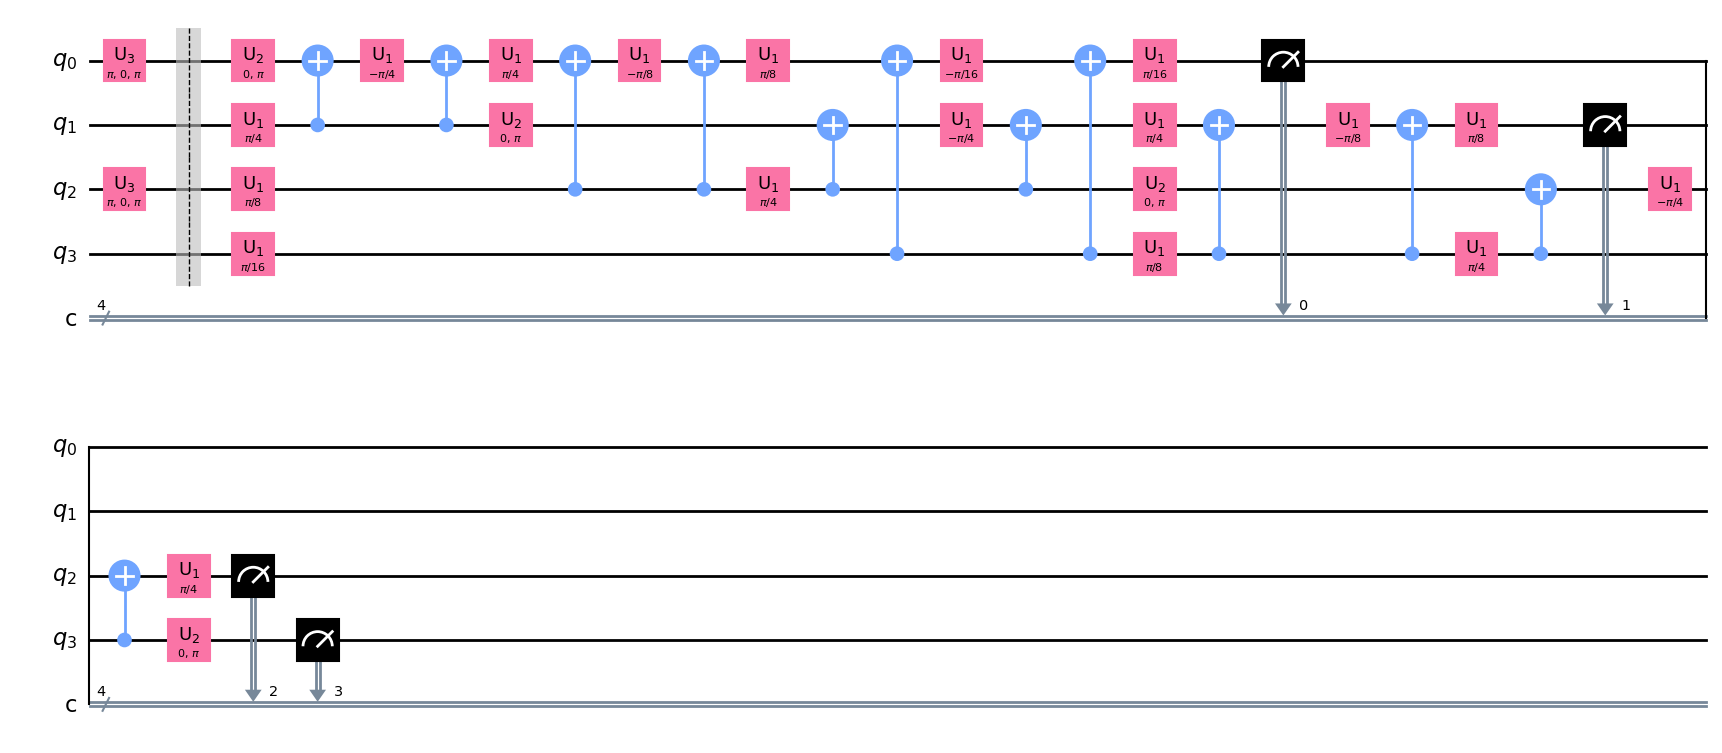

In [3]:
# from transpile_benchy.interfaces.mqt_interface import MQTBench
from transpile_benchy.interfaces.qasm_interface import QASMBench
from transpile_benchy.library import CircuitLibrary

lib = CircuitLibrary(circuit_list=[])
qc = lib.get_circuit("qft_n4")
qc = qc.decompose()
display(qc.draw("mpl"))

In [4]:
# qc.remove_final_measurements()

# qc.save_density_matrix()
# qc.draw("mpl")

In [5]:
# # Create an empty noise model
# from qiskit_aer.noise import (
#     NoiseModel,
#     QuantumError,
#     ReadoutError,
#     pauli_error,
#     depolarizing_error,
#     thermal_relaxation_error,
# )

# # Error probabilities
# prob_1 = 0.001  # 1-qubit gate
# prob_2 = 0.01  # 2-qubit gate

# # Depolarizing quantum errors
# error_1 = depolarizing_error(prob_1, 1)
# error_2 = depolarizing_error(prob_2, 2)

# # Add errors to noise model
# noise_model = NoiseModel()
# noise_model.add_all_qubit_quantum_error(error_1, ["u1", "u2", "u3"])
# noise_model.add_all_qubit_quantum_error(error_2, ["cx"])
# print(noise_model)

Percent volume of A_C2	 | Cost	 | Sequence name
  0.00% =    0/1    	 | 0.00	 | 
  0.00% =    0/1    	 | 0.50	 | xx_plus_yy(-1.57080)
 50.00% =    1/2    	 | 1.00	 | xx_plus_yy(-1.57080).xx_plus_yy(-1.57080)
100.00% =    1/1    	 | 1.50	 | xx_plus_yy(-1.57080).xx_plus_yy(-1.57080).xx_plus_yy(-1.57080)
Percent volume of A_C2	 | Cost	 | Sequence name
  0.00% =    0/1    	 | 0.00	 | 
  0.00% =    0/1    	 | 1.00	 | cx
  0.00% =    0/1    	 | 2.00	 | cx.cx
100.00% =    1/1    	 | 3.00	 | cx.cx.cx
6.5
8.0
0


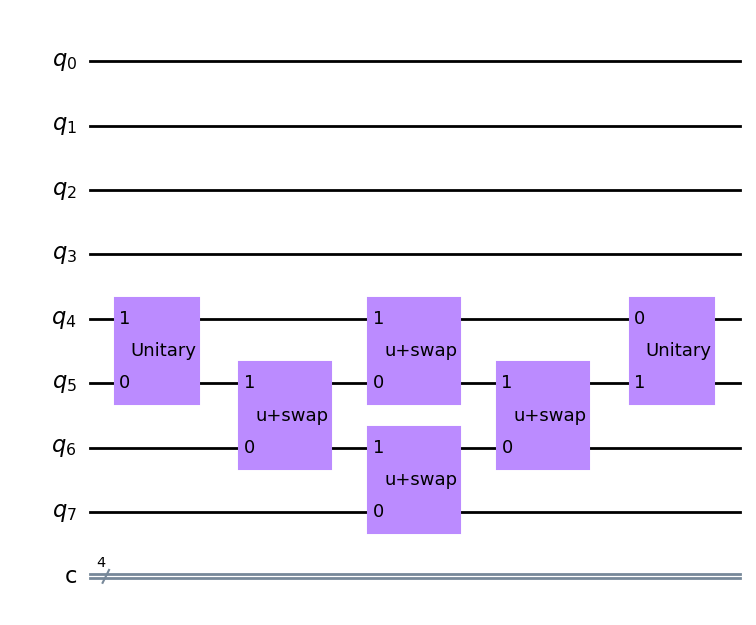

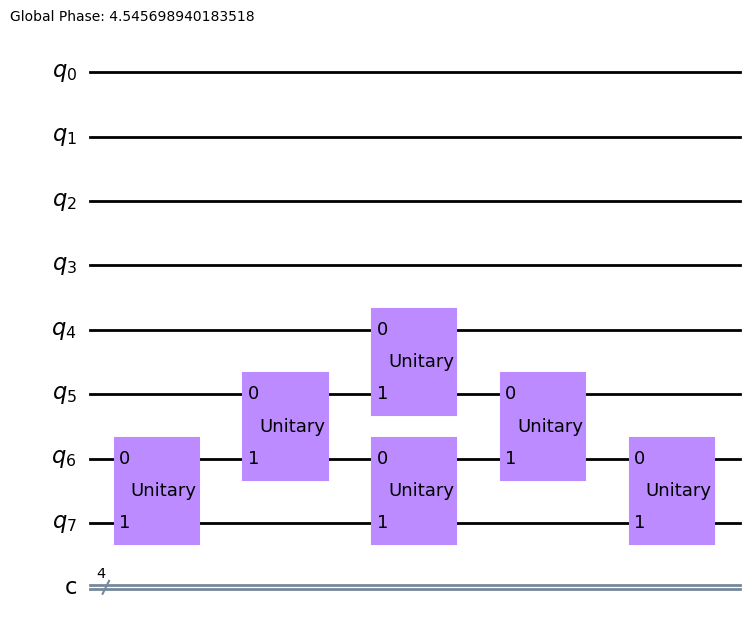

In [6]:
runner = Mirage(
    coupling_map,
    cx_basis=0,
    parallel=0,
    logger=transpile_benchy_logger,
    cost_function="depth",
    # cost_function="basic",
    anneal_routing=True,
    layout_trials=20,
    fb_iters=4,
    # layout_trials=20,
    # fb_iters=4,
    # fixed_aggression=0
    # cost_function="basic",
    use_fast_settings=1,
)

runner.seed = 0
metric = DepthMetric(consolidate=False)
runner._append_metric_pass(metric)
metric = TotalMetric(consolidate=False)
runner._append_metric_pass(metric)
metric = TotalSwaps(consolidate=False)
runner._append_metric_pass(metric)
# metric = TimeMetric()
# runner._append_metric_pass(metric)

transp = runner.run(qc)
# print(runner.property_set["accepted_subs"])
print(runner.property_set["monodromy_depth"])
print(runner.property_set["monodromy_total"])
print(runner.property_set["total_swaps"])
display(runner.property_set["mid"].draw("mpl", fold=-1))
# display(runner.property_set["post0"].draw("mpl"))
display(transp.draw(output="mpl", fold=-1))

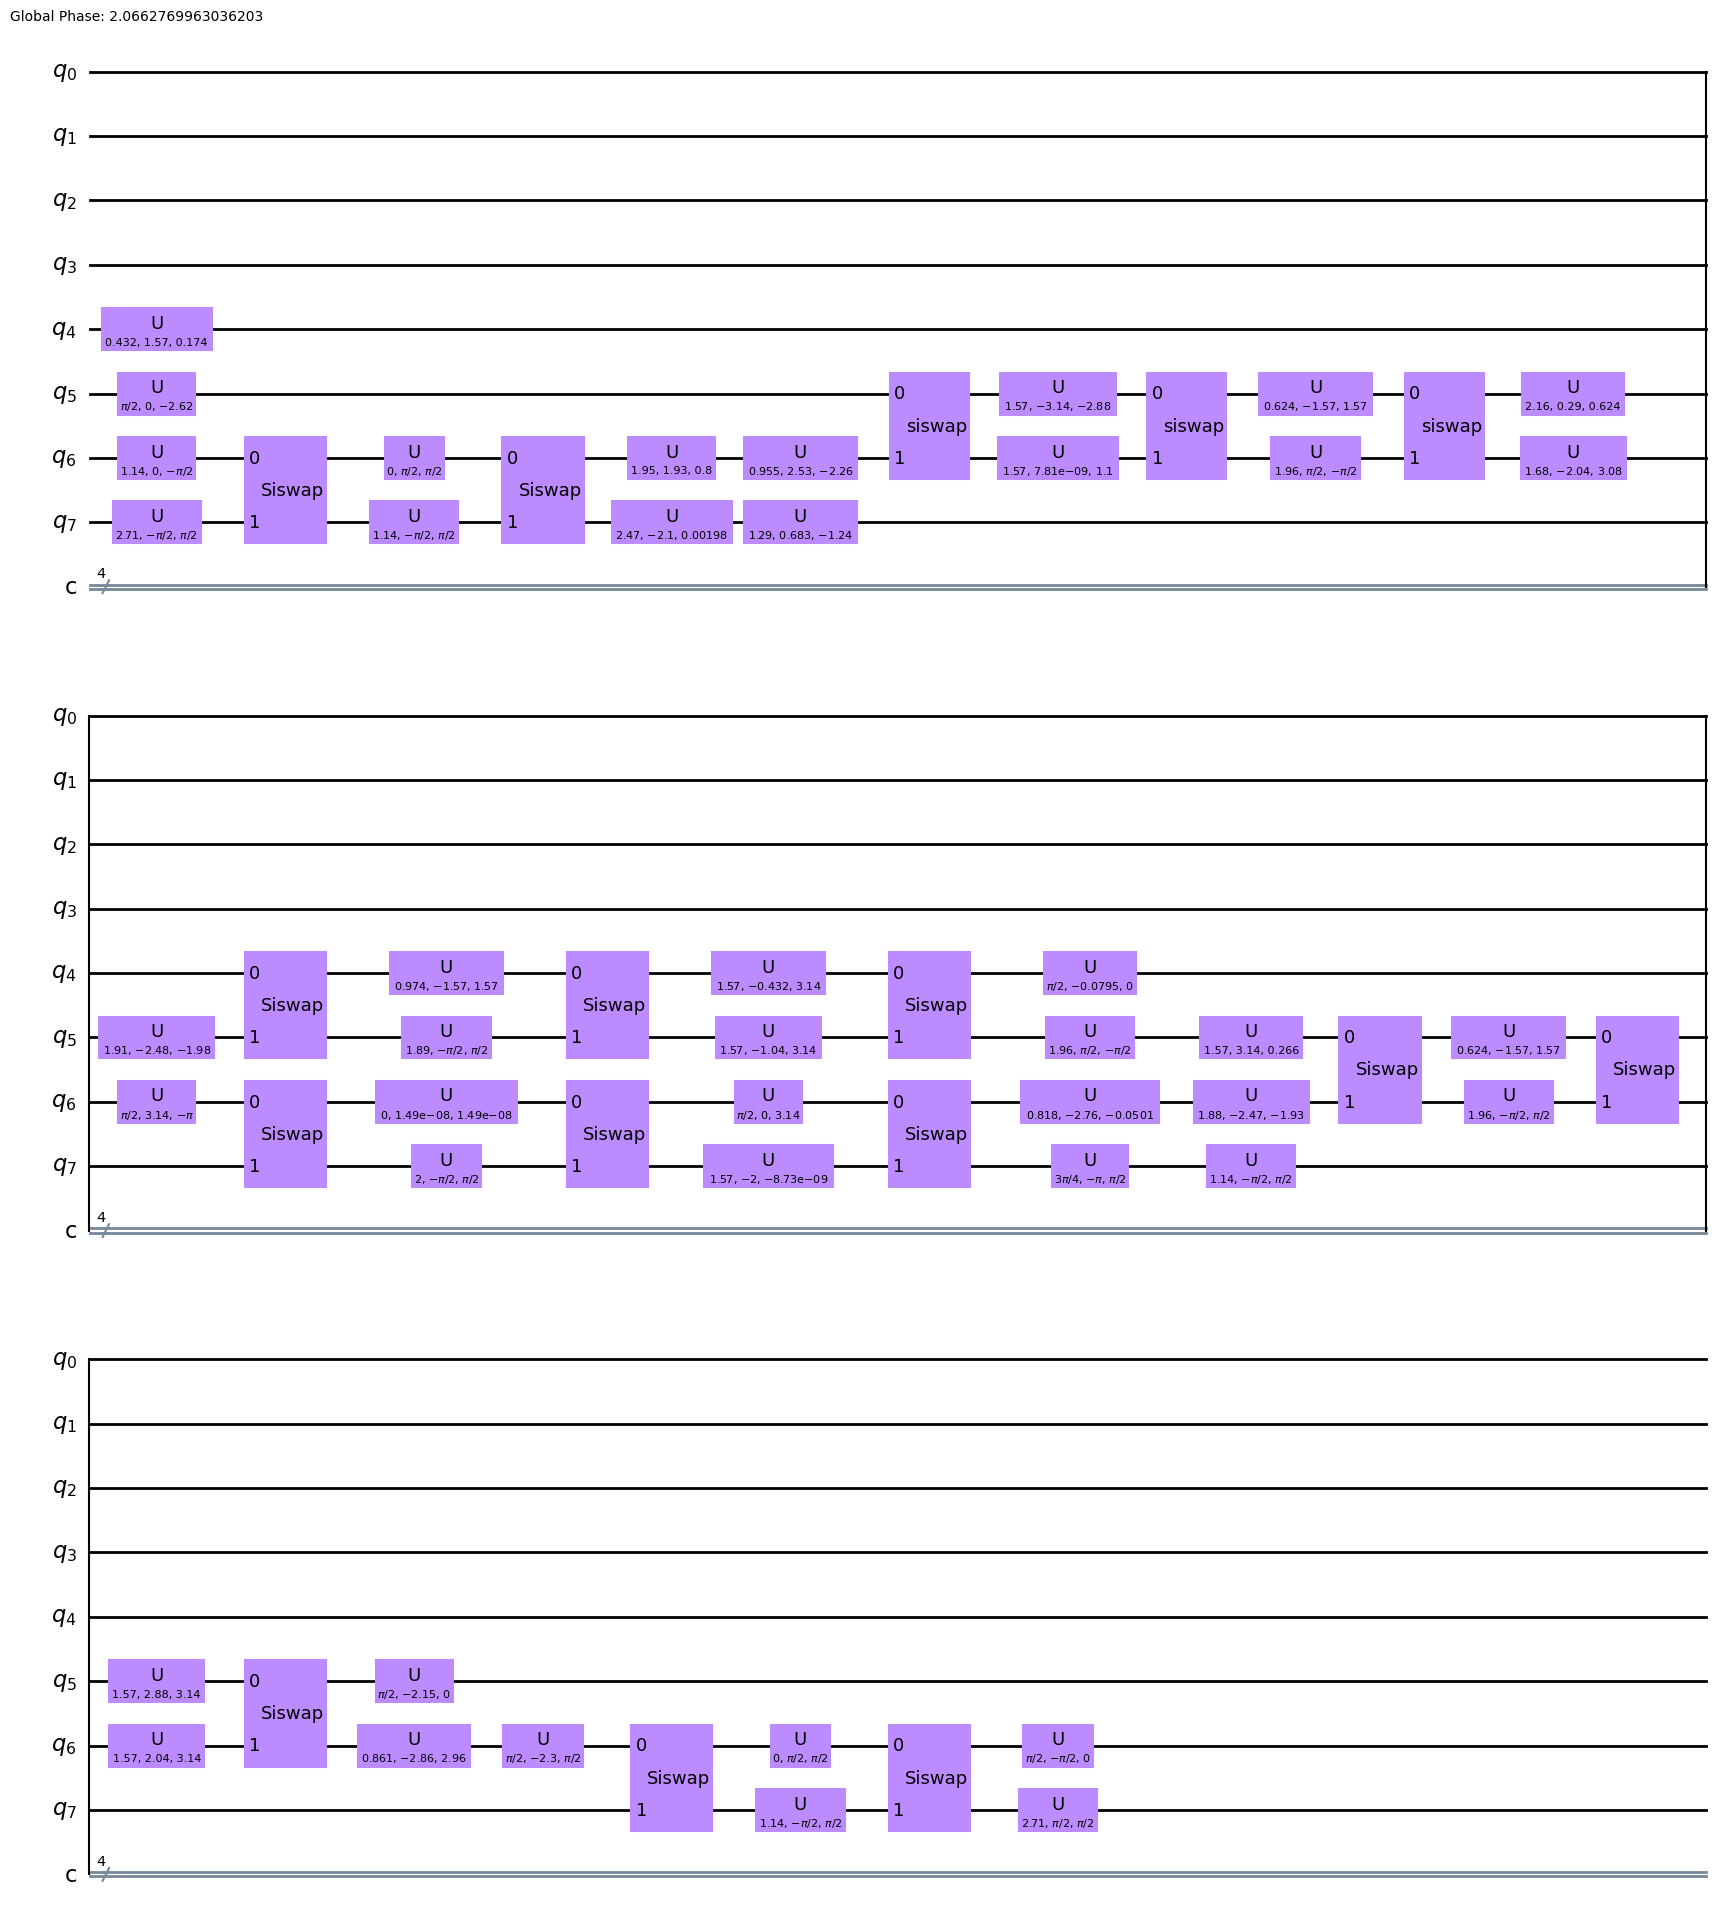

In [7]:
from mirror_gates.sqiswap_decomposer import SiSwapDecomposePass
from qiskit.transpiler.passmanager import PassManager

pm = PassManager()
pm.append(SiSwapDecomposePass())
output = pm.run(transp)
output.draw("mpl")

In [8]:
# from qiskit import transpile

# mirage_qc = transpile(
#     qc,
#     optimization_level=3,
#     coupling_map=coupling_map,
#     basis_gates=["u", "xx_plus_yy", "id"],
#     # basis_gates=["u", "cx"],
#     routing_method="mirage",
#     layout_method="sabre_layout_v2",
# )

# mirage_qc.draw(output="mpl")

8.5
2


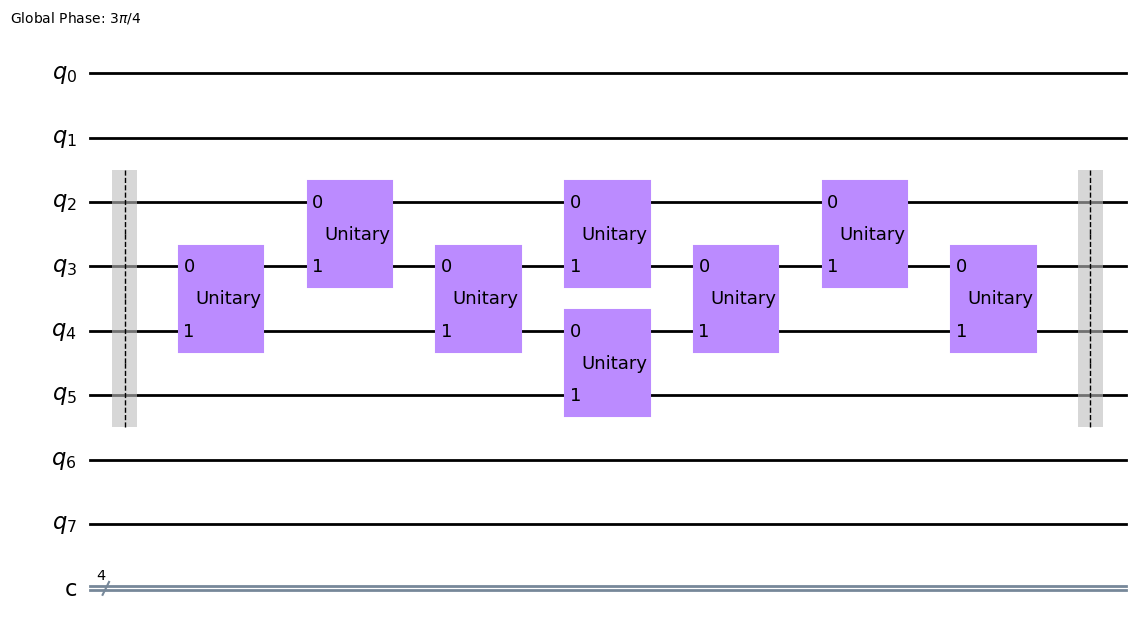

In [9]:
runner = QiskitLevel3(coupling_map, cx_basis=0)
metric = DepthMetric(consolidate=False)
runner._append_metric_pass(metric)
metric = TotalSwaps(consolidate=False)
runner._append_metric_pass(metric)
transp = runner.run(qc)
print(runner.property_set["monodromy_depth"])
print(runner.property_set["total_swaps"])
# print(runner.property_set["monodromy_total"])
display(transp.draw(output="mpl", fold=-1))
# display(runner.property_set["post0"].draw("mpl"))

In [10]:
# from qiskit import Aer, transpile
# from qiskit.quantum_info import state_fidelity
# from qiskit_aer import AerSimulator

# simulator = Aer.get_backend("aer_simulator")
# circ = transpile(qc, simulator)
# result = simulator.run(circ).result()
# perfect_density_matrix = result.data()["density_matrix"]